In [1]:
import pandas as pd
import os

In [50]:
metrics_path = '/Users/Maria.Tigina/PycharmProjects/agents-eval-data/metrics'
agents = ['planning_gpt-4-1106-preview', 'planning_gpt-3.5-turbo-1106', 'vanilla_gpt-4-1106-preview', 'few_shot_fleet_gpt-4-1106-preview']
languages = ['py', 'java', 'kt', 'all']
metrics_categories = ['quality', 'cost', 'qodana']

In [51]:
def read_metrics_for_agent(agent):
    metrics = {}
    for language in languages[:3]:
        metrics[language] = {}
        language_path = os.path.join(metrics_path, agent, language) 
        for metrics_category in metrics_categories:
            metrics_category_path = os.path.join(language_path, f'{metrics_category}_metrics.csv')
            metrics[language][metrics_category] = pd.read_csv(metrics_category_path)
    metrics['all'] = {}
    for metrics_category in metrics_categories:
        metrics['all'][metrics_category] = pd.concat([metrics[language][metrics_category] for language in languages[:3]])
    return metrics


def read_metrics():
    metrics = {}
    for agent in agents:   
        metrics[agent] = read_metrics_for_agent(agent)
    return metrics

In [52]:
metrics = read_metrics()

In [53]:
metrics['planning_gpt-4-1106-preview']['all']['cost'].keys()

Index(['id', 'full_name', 'owner', 'name', 'time', 'total_tokens',
       'prompt_tokens', 'completion_tokens', 'api_calls_count',
       'api_failed_calls_count', 'llm_calls_count', 'langsmith_project_link'],
      dtype='object')

In [54]:
metrics['planning_gpt-4-1106-preview']['all']['quality'].keys()

Index(['id', 'full_name', 'owner', 'name', 'bleu', 'rouge1', 'rouge2',
       'rougeL', 'rougeLsum', 'chrf', 'bertscoref1', 'gte', 'avg_gte_match',
       'uncovered_golden', 'gen_files_count', 'gen_empty_files_count',
       'gen_dirs_count', 'gen_empty_dirs_count', 'gen_file_tree_depth',
       'gen_has_root_dir', 'golden_files_count', 'golden_empty_files_count',
       'golden_dirs_count', 'golden_empty_dirs_count',
       'golden_file_tree_depth', 'golden_has_root_dir'],
      dtype='object')

In [55]:
metrics['planning_gpt-4-1106-preview']['all']['qodana'].keys()

Index(['id', 'full_name', 'owner', 'name', 'logs', 'url', 'problems',
       'problems_count', 'problems_by_name_count', 'open_status', 'error'],
      dtype='object')

In [72]:
import json
import ast

problems = metrics['planning_gpt-4-1106-preview']['py']['qodana']['problems'].dropna()[0]
ast.literal_eval(problems)[0]

{'tool': 'Code Inspection',
 'category': 'Python',
 'type': 'Unsatisfied package requirements',
 'tags': ['Python'],
 'severity': 'High',
 'comment': "Package requirements 'Flask', 'Flask-SQLAlchemy', 'Flask-WTF', 'Flask-Login', 'Flask-Admin' are not satisfied",
 'detailsInfo': 'Reports packages mentioned in requirements files (for example, `requirements.txt` or `Pipfile`) but not installed,\nor imported but not mentioned in requirements files.\n\n\nThe IDE shows a quick-fix banner so that you can install the missing packages in one click.',
 'sources': [{'type': 'file',
   'path': 'config.py',
   'language': '',
   'line': 0,
   'offset': 0,
   'length': 0,
   'code': {'startLine': 0, 'length': 0, 'offset': 0, 'surroundingCode': ''}}],
 'attributes': {'module': 'project',
  'inspectionName': 'PyPackageRequirementsInspection'},
 'hash': '0112ce1200f085d8442c55d4e07a35baa837cbc4695d1b96bfeb9340fe4cb1cf'}

In [74]:
import matplotlib.pyplot as plt
import numpy as np


def plot_bar_for_metric(category: str, metric: str, f: int = 0, golden: bool = False):
    x = np.arange(len(languages))
    width = 0.2
    fig, ax = plt.subplots(figsize=(10, 5))
    
    values = [[list(metrics[a][l][category][metric].dropna()) for l in languages] for a in agents]
    categories = list(languages)
    labels = list(agents)
    if golden:
        golden_metric = metric.replace('gen', 'golden')
        values.append([list(metrics[agents[0]][l][category][golden_metric].dropna()) for l in languages])
        labels.append('golden')
        width = 0.15
    
    for i, l in enumerate(labels):
        average_values = [np.average(values[i][j]) for j in range(len(categories))]
        bar_positions = x - width * len(labels) / 2 + (i + 0.5) * width
        rect = ax.bar(bar_positions, average_values, width, label=labels[i])
        
        for j, rect in enumerate(rect):
            height = rect.get_height() * 0.9
            if len(values[i][j]) == 0:
                continue
            ax.annotate(
                f'min: {np.min(values[i][j]):.{f}f}\n' + 
                f'max: {np.max(values[i][j]):.{f}f}\n' +
                f'avg: {np.average(values[i][j]):.{1}f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')


    ax.set_ylabel('Average value')
    ax.set_title(f'Metric {metric} across languages and agents')
    ax.set_xticks(x)
    ax.set_xticklabels(languages)
    ax.legend()

    ax.grid(True)

    fig.tight_layout()
    plt.show()

# Cost metrics

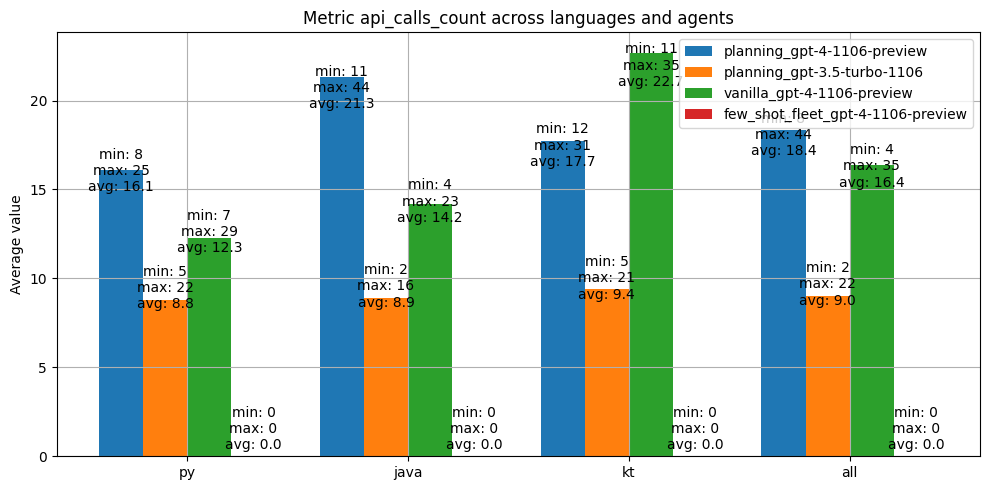

In [8]:
plot_bar_for_metric('cost', 'api_calls_count')

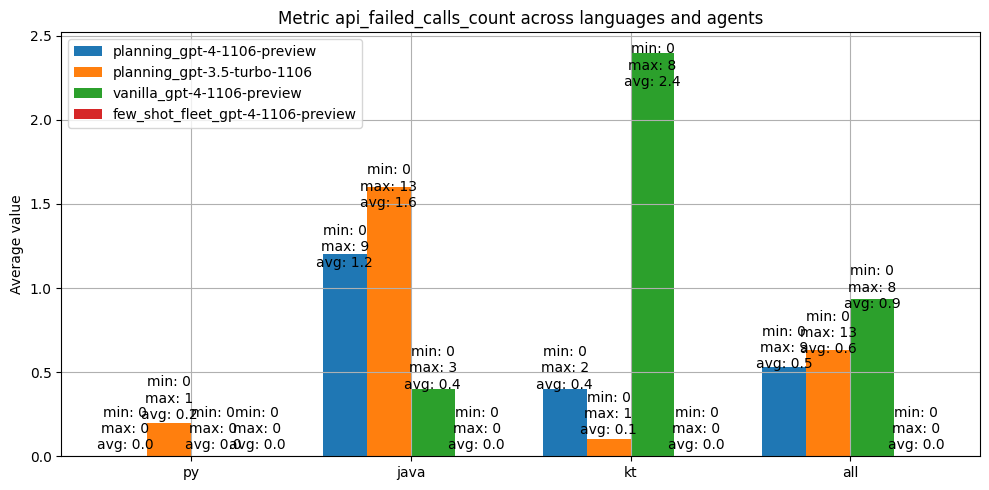

In [9]:
plot_bar_for_metric('cost', 'api_failed_calls_count')

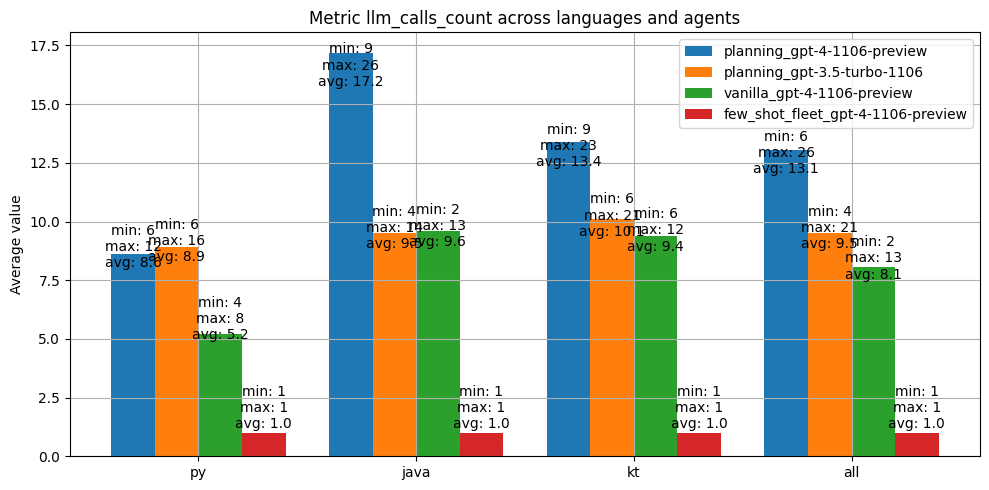

In [10]:
plot_bar_for_metric('cost', 'llm_calls_count')

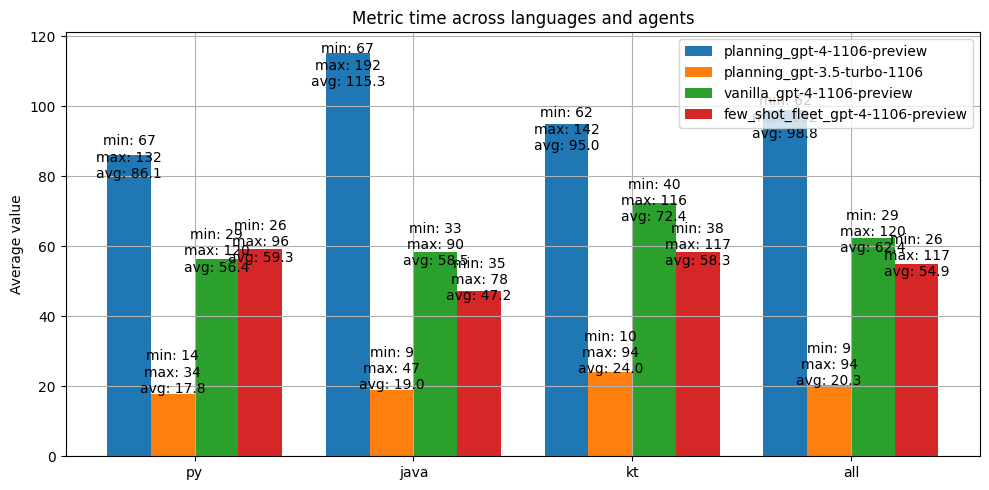

In [11]:
plot_bar_for_metric('cost', 'time')

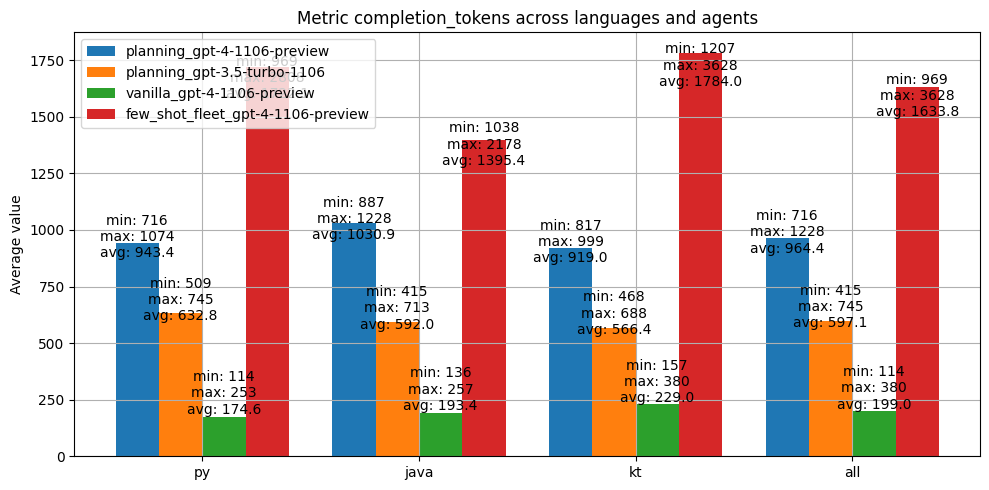

In [12]:
plot_bar_for_metric('cost', 'completion_tokens')

In [13]:
stats = {'metric': [], 'agent': [], 'min': [], 'median': [], 'avg': [], 'max': []}
for metric in ['total_tokens', 'prompt_tokens', 'completion_tokens', 'api_calls_count', 'api_failed_calls_count', 'llm_calls_count']:
    for agent in agents:
        stats['agent'].append(agent)
        stats['metric'].append(metric)
        stats['min'].append(np.min(metrics[agent]['all']['cost'][metric]))
        stats['median'].append(np.median(metrics[agent]['all']['cost'][metric]))
        stats['avg'].append(np.average(metrics[agent]['all']['cost'][metric]))
        stats['max'].append(np.max(metrics[agent]['all']['cost'][metric]))
        
df = pd.DataFrame(stats)
df

,metric,agent,min,median,avg,max
0,total_tokens,planning_gpt-4-1106-preview,6744,14498.0,16753.366667,35767
1,total_tokens,planning_gpt-3.5-turbo-1106,3882,8291.5,9179.933333,18531
2,total_tokens,vanilla_gpt-4-1106-preview,914,3179.0,3058.433333,4940
3,total_tokens,few_shot_fleet_gpt-4-1106-preview,2490,3049.5,3160.633333,5155
4,prompt_tokens,planning_gpt-4-1106-preview,6028,13677.0,15788.933333,34539
5,prompt_tokens,planning_gpt-3.5-turbo-1106,3283,7742.5,8582.866667,17941
6,prompt_tokens,vanilla_gpt-4-1106-preview,712,2939.0,2859.433333,4563
7,prompt_tokens,few_shot_fleet_gpt-4-1106-preview,1514,1526.0,1526.800000,1552
8,completion_tokens,planning_gpt-4-1106-preview,716,966.5,964.433333,1228
9,completion_tokens,planning_gpt-3.5-turbo-1106,415,591.5,597.066667,745


# Quality metrics

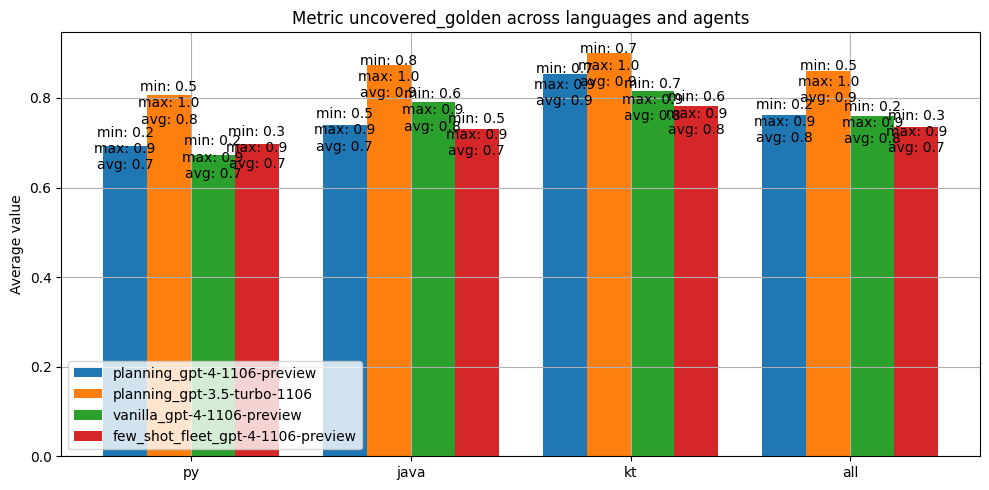

In [14]:
plot_bar_for_metric('quality', 'uncovered_golden', f=1)

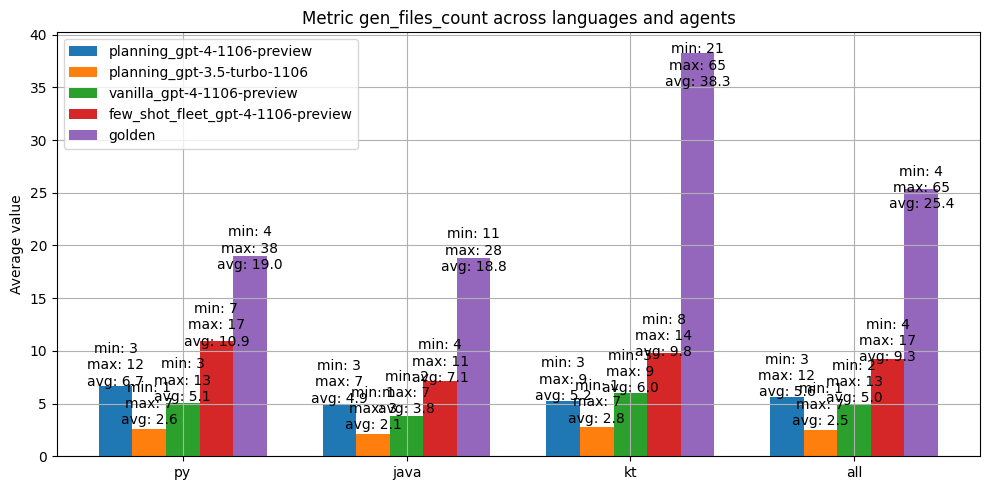

In [15]:
plot_bar_for_metric('quality', 'gen_files_count', golden=True)

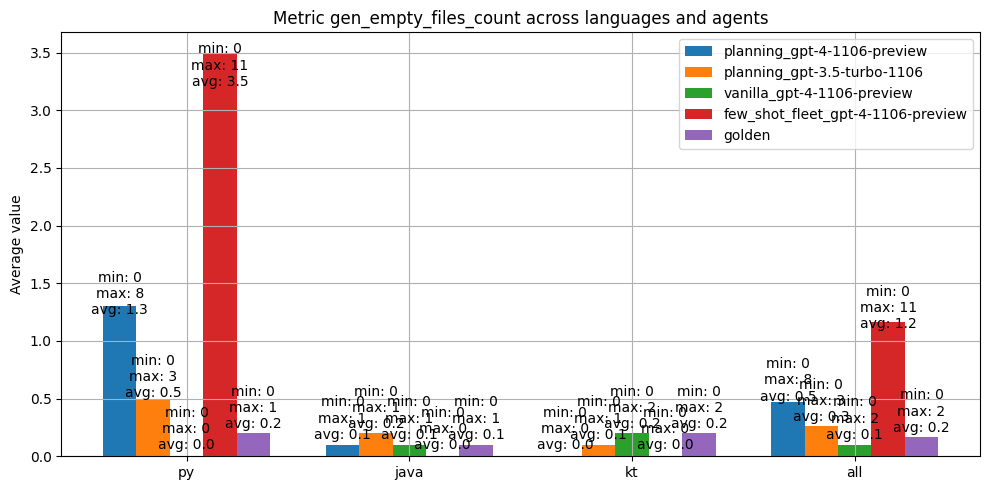

In [16]:
plot_bar_for_metric('quality', 'gen_empty_files_count', golden=True)

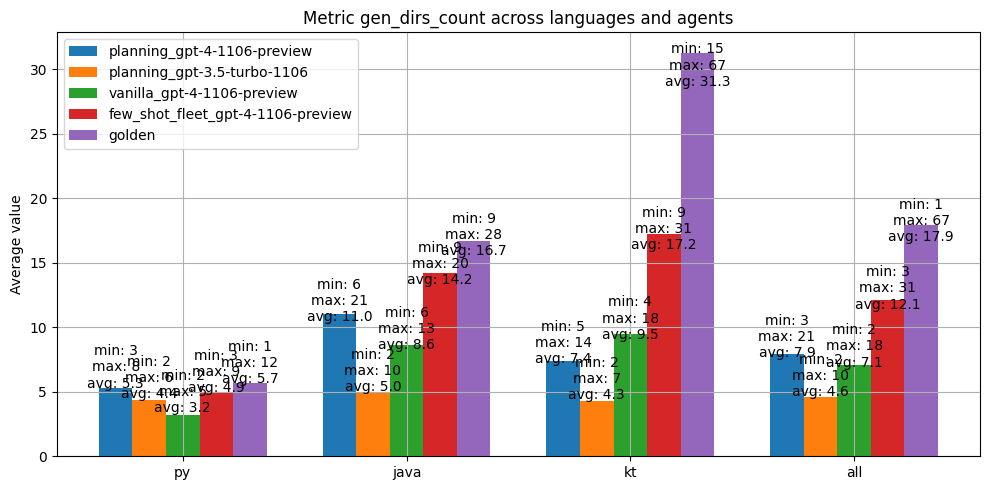

In [17]:
plot_bar_for_metric('quality', 'gen_dirs_count', golden=True)

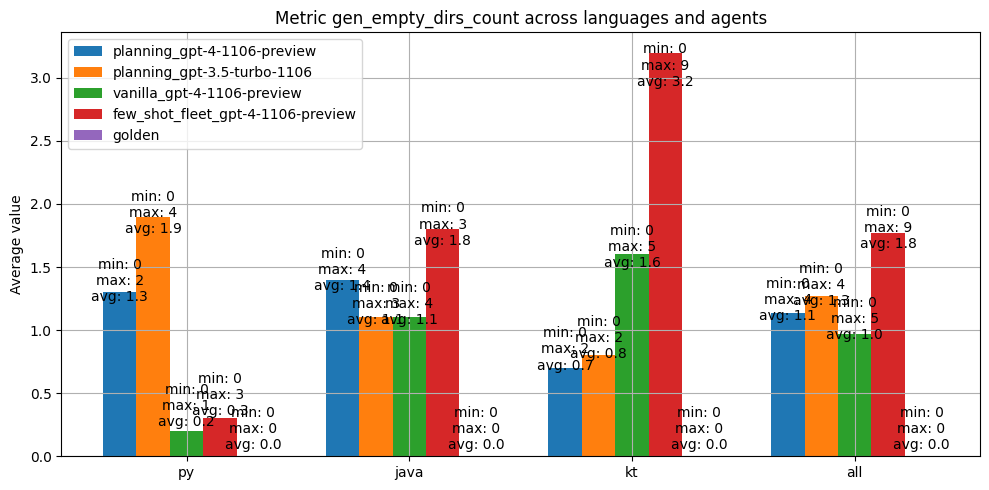

In [18]:
plot_bar_for_metric('quality', 'gen_empty_dirs_count', golden=True)

In [19]:
print('Befause of the test directory is empty in most cases, 2/3 generated projects has empty dir')
len(metrics['planning_gpt-4-1106-preview']['all']['quality'][
    metrics['planning_gpt-4-1106-preview']['all']['quality']['gen_empty_dirs_count'] > 0])

Befause of the test directory is empty in most cases, 2/3 generated projects has empty dir


22

In [20]:
len(metrics['planning_gpt-4-1106-preview']['all']['quality'][
    metrics['planning_gpt-4-1106-preview']['all']['quality']['gen_empty_files_count'] > 0])

5

In [21]:
for agent in agents[:-1]:
    for language in languages:
        for f in ['gen_file_tree_depth', 'golden_file_tree_depth']:
            metrics[agent][language]['quality'][f] = metrics[agent][language]['quality'][f].apply(lambda x: max(0, x - 9))

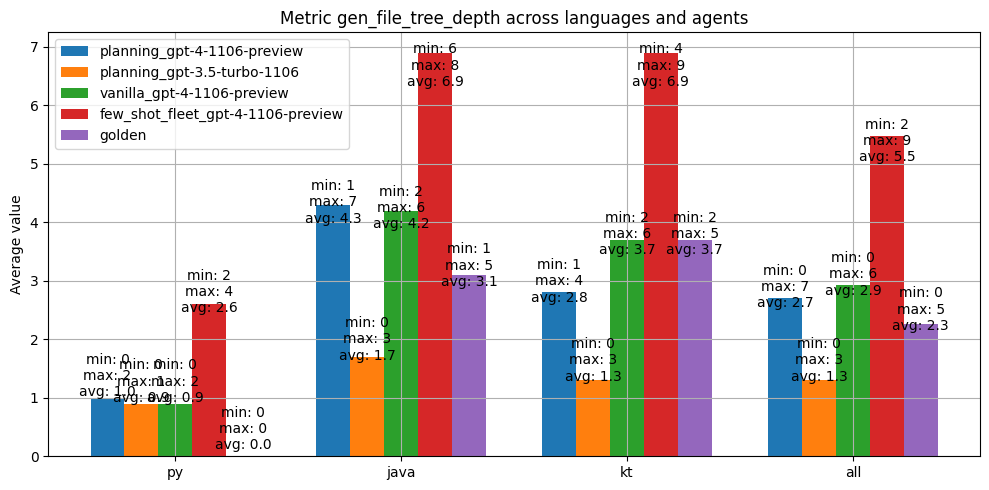

In [22]:
plot_bar_for_metric('quality', 'gen_file_tree_depth', golden=True)

In [23]:
print("In 2/3 tempaltes project agent generates inner directory for project and then create files in it...")
metrics['planning_gpt-4-1106-preview']['all']['quality'][['gen_has_root_dir']].describe()

In 2/3 tempaltes project agent generates inner directory for project and then create files in it...


,gen_has_root_dir
count,30
unique,2
top,True
freq,23


In [24]:
metrics['planning_gpt-4-1106-preview']['all']['quality'].keys()

Index(['id', 'full_name', 'owner', 'name', 'bleu', 'rouge1', 'rouge2',
       'rougeL', 'rougeLsum', 'chrf', 'bertscoref1', 'gte', 'avg_gte_match',
       'uncovered_golden', 'gen_files_count', 'gen_empty_files_count',
       'gen_dirs_count', 'gen_empty_dirs_count', 'gen_file_tree_depth',
       'gen_has_root_dir', 'golden_files_count', 'golden_empty_files_count',
       'golden_dirs_count', 'golden_empty_dirs_count',
       'golden_file_tree_depth', 'golden_has_root_dir'],
      dtype='object')

# Qodana metrics

In [97]:
import ast
from collections import defaultdict
import json

problems_by_name_count = {}

for language in languages:
    problems_by_name_count[language] = {}
    for agent in agents:
        problems_by_name_count[language][agent] = defaultdict(int)
        for problems_str in metrics[agent][language]['qodana']['problems_by_name_count'].dropna():
            problems = ast.literal_eval(problems_str)
            for k, v in problems.items():
                    problems_by_name_count[language][agent][k] += v
        problems_by_name_count[language][agent] = dict(sorted(problems_by_name_count[language][agent].items(), key=lambda item: -item[1]))

print(json.dumps(problems_by_name_count, indent=4))

{
    "py": {
        "planning_gpt-4-1106-preview": {
            "PyPackageRequirementsInspection": 38,
            "PyPep8Inspection": 22,
            "PyUnusedLocalInspection": 1
        },
        "planning_gpt-3.5-turbo-1106": {
            "PyPep8Inspection": 19,
            "PyPackageRequirementsInspection": 14,
            "PyShadowingNamesInspection": 2,
            "PyUnusedLocalInspection": 2
        },
        "vanilla_gpt-4-1106-preview": {
            "PyPackageRequirementsInspection": 28,
            "PyPep8Inspection": 25,
            "PyUnusedLocalInspection": 3,
            "PyUnboundLocalVariableInspection": 1
        },
        "few_shot_fleet_gpt-4-1106-preview": {
            "PyPackageRequirementsInspection": 29,
            "PyPep8Inspection": 20,
            "PyRelativeImportInspection": 2,
            "PyMethodMayBeStaticInspection": 1,
            "PyUnusedLocalInspection": 1
        }
    },
    "java": {
        "planning_gpt-4-1106-preview": {
           

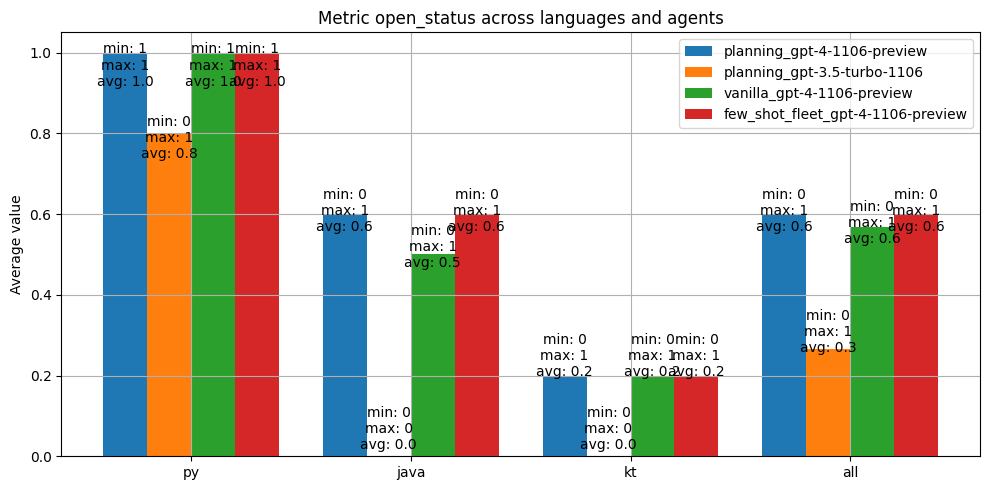

In [76]:
plot_bar_for_metric('qodana', 'open_status', golden=False)

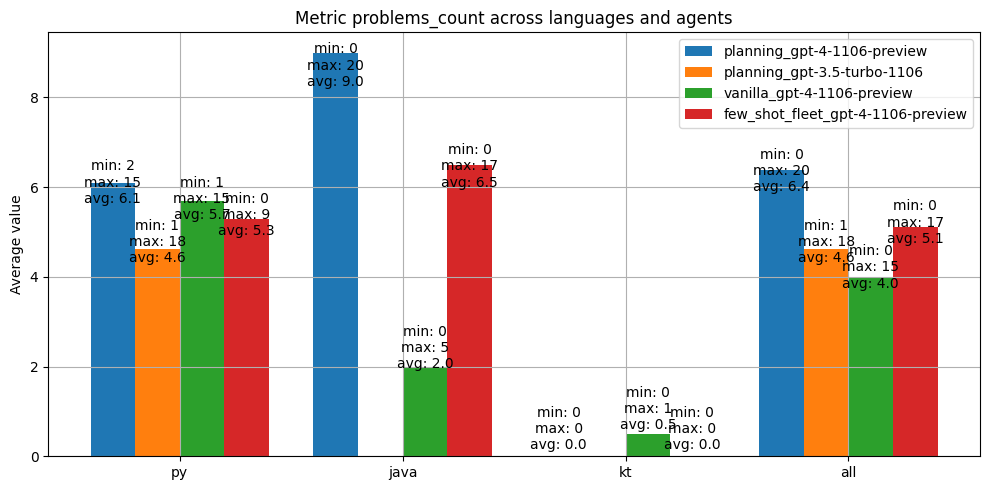

In [75]:
plot_bar_for_metric('qodana', 'problems_count', golden=False)

# Overall metrics

In [78]:
stats = {'metric': [], 'agent': [], 'min': [], 'median': [], 'avg': [], 'max': []}
for metric in ['gen_files_count', 'gen_dirs_count', 'gen_empty_files_count', 'gen_empty_dirs_count', 'gen_has_root_dir', 'gen_file_tree_depth']:
    for agent in agents:
        stats['agent'].append(agent)
        stats['metric'].append(metric)
        stats['min'].append(np.min(metrics[agent]['all']['quality'][metric]))
        stats['median'].append(np.median(metrics[agent]['all']['quality'][metric]))
        stats['avg'].append(np.average(metrics[agent]['all']['quality'][metric]))
        stats['max'].append(np.max(metrics[agent]['all']['quality'][metric]))
        
    stats['agent'].append('golden')
    golden_metric = metric.replace('gen', 'golden')
    stats['metric'].append(metric)
    stats['min'].append(np.min(metrics[agent]['all']['quality'][golden_metric]))
    stats['median'].append(np.median(metrics[agent]['all']['quality'][golden_metric]))
    stats['avg'].append(np.average(metrics[agent]['all']['quality'][golden_metric]))
    stats['max'].append(np.max(metrics[agent]['all']['quality'][golden_metric]))
    
df = pd.DataFrame(stats)
df

,metric,agent,min,median,avg,max
0,gen_files_count,planning_gpt-4-1106-preview,3,5.0,5.600000,12
1,gen_files_count,planning_gpt-3.5-turbo-1106,1,2.0,2.500000,7
2,gen_files_count,vanilla_gpt-4-1106-preview,2,4.0,4.966667,13
3,gen_files_count,few_shot_fleet_gpt-4-1106-preview,4,9.0,9.266667,17
4,gen_files_count,golden,4,23.0,25.366667,65
5,gen_dirs_count,planning_gpt-4-1106-preview,3,7.0,7.900000,21
6,gen_dirs_count,planning_gpt-3.5-turbo-1106,2,5.0,4.566667,10
7,gen_dirs_count,vanilla_gpt-4-1106-preview,2,7.5,7.100000,18
8,gen_dirs_count,few_shot_fleet_gpt-4-1106-preview,3,13.0,12.100000,31
9,gen_dirs_count,golden,1,15.5,17.900000,67
